In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from imblearn.over_sampling import SMOTE

## Data Loading

In [131]:
df = pd.read_csv("application_record.csv")
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
ID                     438557 non-null int64
CODE_GENDER            438557 non-null object
FLAG_OWN_CAR           438557 non-null object
FLAG_OWN_REALTY        438557 non-null object
CNT_CHILDREN           438557 non-null int64
AMT_INCOME_TOTAL       438557 non-null float64
NAME_INCOME_TYPE       438557 non-null object
NAME_EDUCATION_TYPE    438557 non-null object
NAME_FAMILY_STATUS     438557 non-null object
NAME_HOUSING_TYPE      438557 non-null object
DAYS_BIRTH             438557 non-null int64
DAYS_EMPLOYED          438557 non-null int64
FLAG_MOBIL             438557 non-null int64
FLAG_WORK_PHONE        438557 non-null int64
FLAG_PHONE             438557 non-null int64
FLAG_EMAIL             438557 non-null int64
OCCUPATION_TYPE        304354 non-null object
CNT_FAM_MEMBERS        438557 non-null float64
dtypes: float64(2), int64(8), object(8)
memory usage: 60.2+ MB


In [133]:
# 43万行，18个feature，cross sectional data，没有时间，每一行是一个observation，也就是用户信息
df.shape

(438557, 18)

In [134]:
# 去掉ID重复的
df_remove_dup = df.drop_duplicates(subset = df.columns[0], keep='first', inplace=False)

In [135]:
df_remove_dup.shape

(438510, 18)

In [136]:
df_response = pd.read_csv("credit_record.csv")

In [137]:
df_response.tail()

,ID,MONTHS_BALANCE,STATUS
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C
1048574,5150487,-29,C


In [138]:
df_response[df_response['ID'] == 5008809]
# 从这里可以看出，每一个用户不仅仅被记录了一次

,ID,MONTHS_BALANCE,STATUS
93004,5008809,-22,X
93005,5008809,-23,X
93006,5008809,-24,X
93007,5008809,-25,X
93008,5008809,-26,X


In [139]:
# df_response可以和df（user information）用ID join在一起
df_response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
ID                1048575 non-null int64
MONTHS_BALANCE    1048575 non-null int64
STATUS            1048575 non-null object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


## 处理Response Variable

In [140]:
# 由于每一个用户多次记录，只取信用最差的一次
df_response_single = df_response.groupby('ID').STATUS.max()
df_response_single = df_response_single.reset_index()

In [141]:
df_response_single.shape

(45985, 2)

In [142]:
df_final = pd.merge(df_remove_dup, df_response_single, how='inner', on=['ID'])

In [143]:
# merge两个表
df_final.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,X
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,X
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,X
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,X
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,X


In [144]:
# STATUS是我们用来划定一个用户是defaulter的变量，STATUS本身不是response variable，需要我们划定一个边界来生成response variable
df_final["STATUS"].value_counts()

X    19648
C    11759
0     4282
1      660
5       48
2       48
3        9
4        3
Name: STATUS, dtype: int64

0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month 

从字段可以看出，C是付清，1-5是不同程度的逾期或者烂账，X表示无贷款。我们需要在这个基础上划定一个界限。
*其实应该用更复杂的方法界定，比如这个项目推荐的vintage analysis。这里我们用简单的方法就好了。

In [145]:
# 看一下各种类型的占比 比如C（付清）就是53%,1-29天是32%
df_final["STATUS"].value_counts() / df_final.shape[0]*100

X    53.893628
C    32.254437
0    11.745344
1     1.810352
5     0.131662
2     0.131662
3     0.024687
4     0.008229
Name: STATUS, dtype: float64

这里我们界定方法是，STATUS 0-5也就是有逾期，我们就认为这个客户是defaulter，defaulter = 1。
C和X是非defaulter，defaulter = 0。

In [146]:
df_final['defaulter'] = np.where(df_final["STATUS"].isin(["0","1","2","3","4","5"]), 1, 0)

In [147]:
df_final['defaulter'].value_counts()

0    31407
1     5050
Name: defaulter, dtype: int64

In [148]:
df_final.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'STATUS', 'defaulter'], dtype='object')

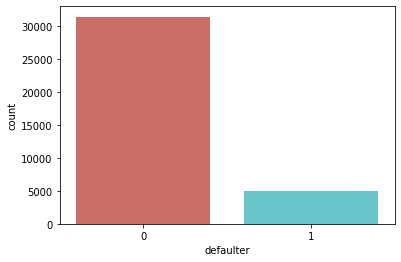

In [149]:
chart=sns.countplot(x ='defaulter', data = df_final, palette = 'hls')

现在我们的response variable 就是defaulter这一列。数据集不平衡，需要过采样或者欠采样。

## 特征工程

In [150]:
df_final.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS,defaulter
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,X,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,X,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,X,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,X,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,X,0


In [151]:
# 去掉STATUS
df_final.drop("STATUS",axis=1,inplace=True)

In [152]:
df_final.dropna(inplace=True)
df_final.shape

(25134, 19)

In [153]:
# 区分连续数据和分类数据
unique_values = {}

for i in df_final.columns:
    unique_values[i] = len(set(df_final[i]))

unique_values

{'ID': 25134,
 'CODE_GENDER': 2,
 'FLAG_OWN_CAR': 2,
 'FLAG_OWN_REALTY': 2,
 'CNT_CHILDREN': 9,
 'AMT_INCOME_TOTAL': 195,
 'NAME_INCOME_TYPE': 5,
 'NAME_EDUCATION_TYPE': 5,
 'NAME_FAMILY_STATUS': 5,
 'NAME_HOUSING_TYPE': 6,
 'DAYS_BIRTH': 5206,
 'DAYS_EMPLOYED': 3299,
 'FLAG_MOBIL': 1,
 'FLAG_WORK_PHONE': 2,
 'FLAG_PHONE': 2,
 'FLAG_EMAIL': 2,
 'OCCUPATION_TYPE': 18,
 'CNT_FAM_MEMBERS': 10,
 'defaulter': 2}

In [154]:
# here, I just assume 19 is a threshold of categorial and continuous variables
for i,j in unique_values.items():
    if j < 19:
        print(set(df_final[i]))

{'F', 'M'}
{'N', 'Y'}
{'N', 'Y'}
{0, 1, 2, 3, 4, 5, 7, 14, 19}
{'Commercial associate', 'State servant', 'Pensioner', 'Working', 'Student'}
{'Academic degree', 'Lower secondary', 'Incomplete higher', 'Higher education', 'Secondary / secondary special'}
{'Separated', 'Single / not married', 'Widow', 'Civil marriage', 'Married'}
{'House / apartment', 'Co-op apartment', 'Municipal apartment', 'Rented apartment', 'Office apartment', 'With parents'}
{1}
{0, 1}
{0, 1}
{0, 1}
{'Secretaries', 'Low-skill Laborers', 'Waiters/barmen staff', 'Realty agents', 'High skill tech staff', 'Medicine staff', 'IT staff', 'Laborers', 'Sales staff', 'Cooking staff', 'Managers', 'Drivers', 'Security staff', 'Private service staff', 'Accountants', 'HR staff', 'Cleaning staff', 'Core staff'}
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, 15.0, 20.0}
{0, 1}


In [155]:
cat_variables = [i for i in unique_values.keys() if unique_values[i] < 19]
con_variables = [i for i in unique_values.keys() if unique_values[i] > 19]
# Y is the response variable, our target
cat_variables.remove("defaulter")
con_variables.remove("ID")
print("The continuous variables: ",con_variables)
print("The categorial variables: ",cat_variables)

The continuous variables:  ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
The categorial variables:  ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']


In [156]:
# 全是1，没有任何意义
df_final.FLAG_MOBIL.value_counts()

1    25134
Name: FLAG_MOBIL, dtype: int64

In [157]:
df_final.drop("FLAG_MOBIL",axis=1,inplace=True)

In [158]:
# 划分数据集
Y = df_final["defaulter"]
X = df_final.drop(['defaulter', 'ID'], axis= 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [159]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((20107, 16), (5027, 16), (20107,), (5027,))

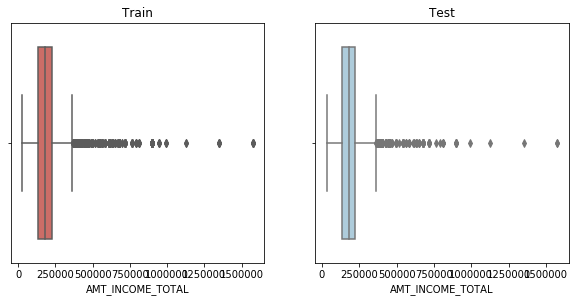

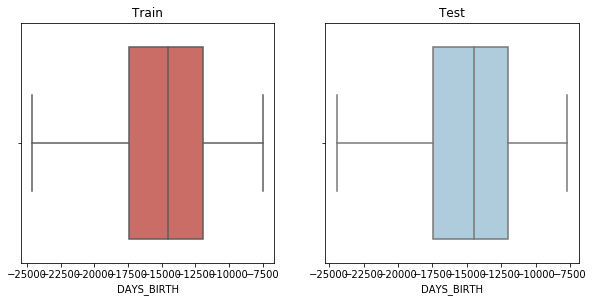

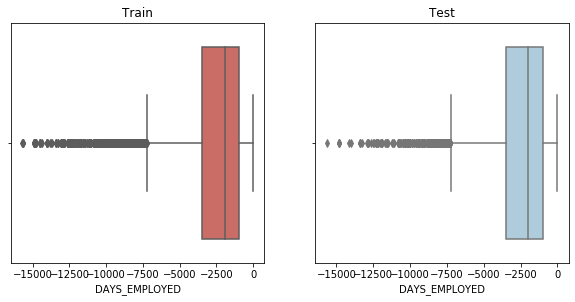

In [160]:
count = 1

for i in range(len(con_variables)):
    fig = plt.figure(figsize = (10,15))
    plt.subplot(len(con_variables),2,count)
    sns.boxplot(x_train[con_variables[i]],palette="hls")
    plt.title("Train")
    
    plt.subplot(len(con_variables),2,count+1)
    sns.boxplot(x_test[con_variables[i]],palette="Paired")
    plt.title("Test")
    count += 2
    
# 主要是对比测试集和训练集数据分布是否一致，来保证模型可靠性

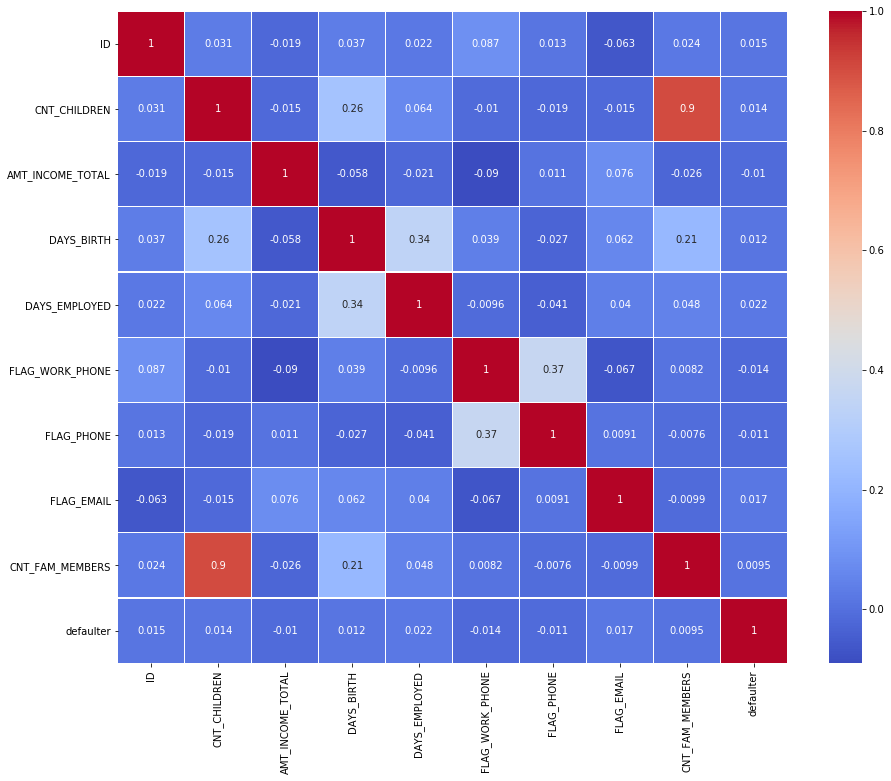

In [161]:
plt.figure(figsize=(15,12))
sns.heatmap(df_final.corr(),cmap='coolwarm',linecolor='white',linewidths=0.25,annot=True)
plt.show()

In [162]:
# CNT_FAM_MEMBERS 和 CNT_CHILDREN 相关性0.9,剔除
df_final.CNT_FAM_MEMBERS.value_counts()

2.0     12697
3.0      5216
1.0      4263
4.0      2576
5.0       307
6.0        51
7.0        18
15.0        3
9.0         2
20.0        1
Name: CNT_FAM_MEMBERS, dtype: int64

In [163]:
df_final.CNT_CHILDREN.value_counts()

0     15908
1      6118
2      2715
3       312
4        57
5        18
14        3
7         2
19        1
Name: CNT_CHILDREN, dtype: int64

In [164]:
#去掉相对复杂的
df_final.drop("CNT_FAM_MEMBERS",axis=1,inplace=True)

In [165]:
x_train.drop("CNT_FAM_MEMBERS",axis=1,inplace=True)
x_test.drop("CNT_FAM_MEMBERS",axis=1,inplace=True)

/Users/hkmac/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [166]:
# 看有没有variance较低的需要剔除
df_final[con_variables].describe().loc["std",:]
# here, we do not have any feature with a very low variance (nearly zero)

AMT_INCOME_TOTAL    104510.987243
DAYS_BIRTH            3486.969790
DAYS_EMPLOYED         2339.224822
Name: std, dtype: float64

In [167]:
x_train.shape

(20107, 15)

In [168]:
# 将分类数据（字符串类型）转化为dummy variable
x_train = pd.get_dummies(x_train,drop_first=True)
x_test = pd.get_dummies(x_test,drop_first=True)

In [169]:
x_trian.shape, x_test.shape

((20107, 52), (5027, 44))

In [172]:
x_train.columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_High skill tech staff',
       'OCCUPA

In [173]:
# 采用SMOTE算法生成人工样本，解决不平衡问题
sm = SMOTE(sampling_strategy='minority', random_state=10)
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)

In [174]:
x_resampled.shape

(34604, 44)

In [175]:
y_resampled.shape

(34604,)

In [176]:
y_resampled.value_counts()
# 得到了平衡的label

1    17302
0    17302
Name: defaulter, dtype: int64

## 模型

这里先用了一个OLS模型，普通最小二乘(OLS)。因为这个包和上课讲的比较类似，偏统计类型。

In [177]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [178]:
import statsmodels.api as sm

In [179]:
# 普通最小二乘(OLS)
model = sm.OLS(y_resampled, x_resampled) 
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              defaulter   R-squared (uncentered):                   0.616
Model:                            OLS   Adj. R-squared (uncentered):              0.615
Method:                 Least Squares   F-statistic:                              1259.
Date:                Thu, 03 Dec 2020   Prob (F-statistic):                        0.00
Time:                        03:47:53   Log-Likelihood:                         -20558.
No. Observations:               34604   AIC:                                  4.120e+04
Df Residuals:                   34560   BIC:                                  4.158e+04
Df Model:                          44                                                  
Covariance Type:            nonrobust                                                  
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--

根据这个结果可以结合下课上的内容. The condition number is large, 1.45e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
多重共线性很强，参考最下面这个 Cond. No. 很大

In [184]:
## 随机森林模型

In [181]:
rfModel = RandomForestClassifier(class_weight = {0:1,1:10})
rfModel = rfModel.fit(x_resampled, y_resampled)
y_pred = rfModel.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      4312
           1       0.25      0.45      0.32       715

    accuracy                           0.73      5027
   macro avg       0.57      0.61      0.57      5027
weighted avg       0.80      0.73      0.76      5027



In [182]:
def search_model(x_train, y_train, est, param_grid, n_jobs, cv):
    model = GridSearchCV(estimator = est,
                                     param_grid = param_grid,
                                     scoring = 'f1_weighted',
                                     # controls the verbosity: the higher, the more messages
                                     verbose = 10,
                                     # number of jobs to run in parallel.
                                     n_jobs = n_jobs,
                                     # return the average score across folds, weighted by the number of samples in each test set.
                                     iid = True,
                                     # cross-validation generator or an iterable
                                     cv = cv)
    # fit grid search model
    model.fit(x_resampled, y_resampled)   
    return model

In [186]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[100,300,500],
             'criterion':['gini', 'entropy'],
             'class_weight': [{0:1, 1:10}]}

# a prameter grid was given for our model, and we will iterate over different combination of gini and entropy.
# Find the optimal combination according to F1-score.
rfModel = search_model(x_train.values, y_train.values, RandomForestClassifier(), param_grid, -1, 5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   49.5s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   55.2s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.2min remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished
/Users/hkmac/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [187]:
print("Best score: %0.3f" % rfModel.best_score_)
print("Best parameters set:", rfModel.best_params_)

Best score: 0.851
Best parameters set: {'class_weight': {0: 1, 1: 10}, 'criterion': 'entropy', 'n_estimators': 100}


In [188]:
# 经过grid search随机森林准确率可以到85%左右。